<!-- #collapse -->
# Make a Graph

<!-- #collapse -->
## Load a Graph

In [1]:
import json

with open("./data/ids_forwards_posts_1kk.json") as f:
    data = json.load(f)

In [2]:
data[0]

{'from': 236775,
 'to': 99984,
 'posts': [{'post_id': 180685, 'date': '2023-02-07T11:28:32', 'views': 819}]}

In [3]:
from datetime import datetime
from tqdm import tqdm


edges = [(d["to"], d["from"]) for d in data]
weights = [len(d["posts"]) for d in data]

dates = [[datetime.fromisoformat(p['date']) for p in d["posts"]] for d in tqdm(data)]
views = [[p['views'] for p in d["posts"]] for d in tqdm(data)]
post_ids = [[p['post_id'] for p in d['posts']] for d in tqdm(data)]

100%|██████████| 929891/929891 [00:02<00:00, 384007.80it/s] 


In [4]:
from igraph import Graph

# Create the directed graph
G = Graph(edges=edges, directed=True)
G.es['weight'] = weights
G.es['dates'] = dates
G.es['views'] = views
G.es['post_ids'] = post_ids

for vertex in G.vs:
    vertex['id'] = vertex.index

<!-- #collapse -->
## Explanatory statistics

In [5]:
import numpy as np

print("Number of posts:", sum(G.es['weight']))
print("Number of vertex:", G.vcount())
print("Number of edges:", G.ecount())

print("Min number of shared posts:", np.min(G.es['weight']))
print("Max number of shared posts:", np.max(G.es['weight']))

Number of posts: 25917123
Number of vertex: 278500
Number of edges: 929891
Min number of shared posts: 1
Max number of shared posts: 221345


In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Boxplot of distribution of shared posts between channels')

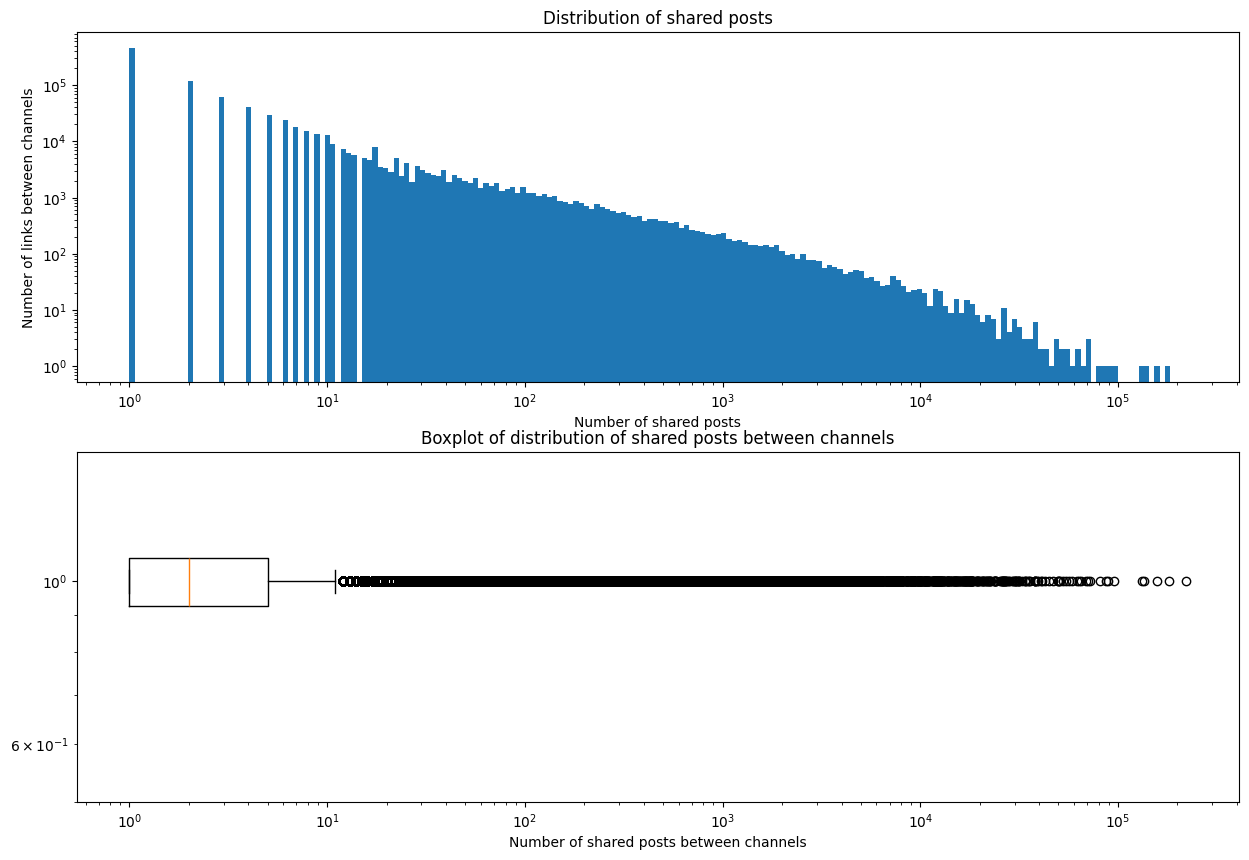

In [8]:
%load_ext autoreload
%autoreload 2
from visualize import plot_loghist


all_weights = G.es['weight']

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

plot_loghist(all_weights, bins=200, ax=axs[0])

axs[0].set_xlabel("Number of shared posts")
axs[0].set_ylabel("Number of links between channels")
axs[0].set_title("Distribution of shared posts")

axs[1].boxplot(all_weights, vert=False)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Number of shared posts between channels')
axs[1].set_title('Boxplot of distribution of shared posts between channels')

100%|██████████| 929891/929891 [00:02<00:00, 322326.27it/s]


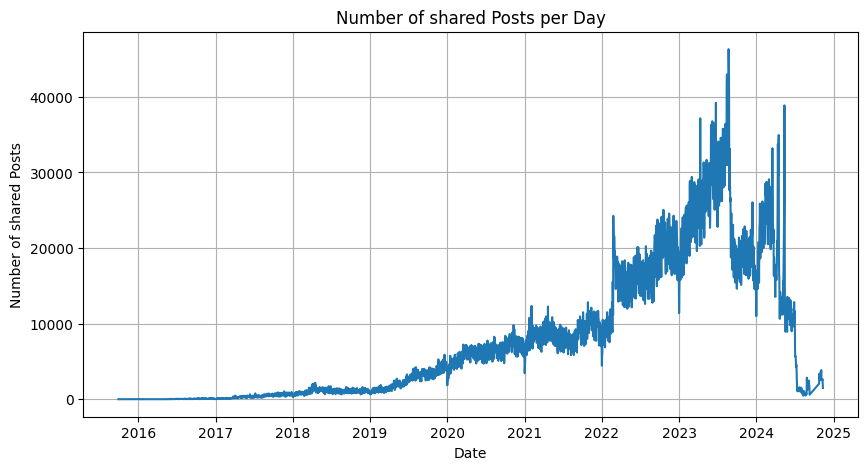

In [9]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

post_counts = defaultdict(int)


for edge in tqdm(G.es):
    for d in edge['dates']:
        # date = datetime.fromisoformat(post['date']).date()
        post_counts[d.date()] += 1

df = pd.DataFrame(list(post_counts.items()), columns=['Date', 'Post Count'])
df = df.sort_values('Date')

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Post Count'])
plt.xlabel('Date')
plt.ylabel('Number of shared Posts')
plt.title('Number of shared Posts per Day')
plt.grid()
plt.show()

100%|██████████| 929891/929891 [00:04<00:00, 230928.81it/s]


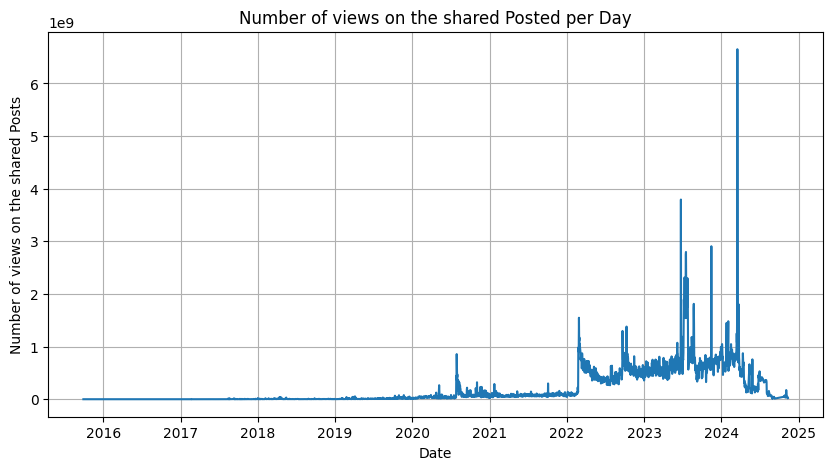

In [10]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

post_counts = defaultdict(int)


for edge in tqdm(G.es):
    for d, v in zip(edge['dates'], edge['views']):
        # date = datetime.fromisoformat(post['date']).date()
        post_counts[d.date()] += v if v else 0

df = pd.DataFrame(list(post_counts.items()), columns=['Date', 'Post Count'])
df = df.sort_values('Date')

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Post Count'])
plt.xlabel('Date')
plt.ylabel('Number of views on the shared Posts')
plt.title('Number of views on the shared Posted per Day')
plt.grid()
plt.show()

In [11]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year from 'Date' column
df['Year'] = df['Date'].dt.year

# Get 5 dates with the highest post counts per year
top_dates_per_year = df.groupby('Year').apply(lambda x: x.nlargest(2, 'Post Count')).reset_index(drop=True)
print(top_dates_per_year)

         Date  Post Count  Year
0  2015-10-01        1118  2015
1  2015-10-27         829  2015
2  2016-12-06      794395  2016
3  2016-12-02      625770  2016
4  2017-08-20    18873887  2017
5  2017-09-10    16394778  2017
6  2018-04-17    41838300  2018
7  2018-04-13    39305580  2018
8  2019-11-22    77585600  2019
9  2019-10-30    75394479  2019
10 2020-07-29   857322929  2020
11 2020-07-30   607796927  2020
12 2021-10-04   299624572  2021
13 2021-01-23   288909872  2021
14 2022-02-27  1547891634  2022
15 2022-10-10  1380195724  2022
16 2023-06-24  3794055168  2023
17 2023-11-15  2906587487  2023
18 2024-03-17  6650550897  2024
19 2024-03-18  3697245392  2024


/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_6845/283605212.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_dates_per_year = df.groupby('Year').apply(lambda x: x.nlargest(2, 'Post Count')).reset_index(drop=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


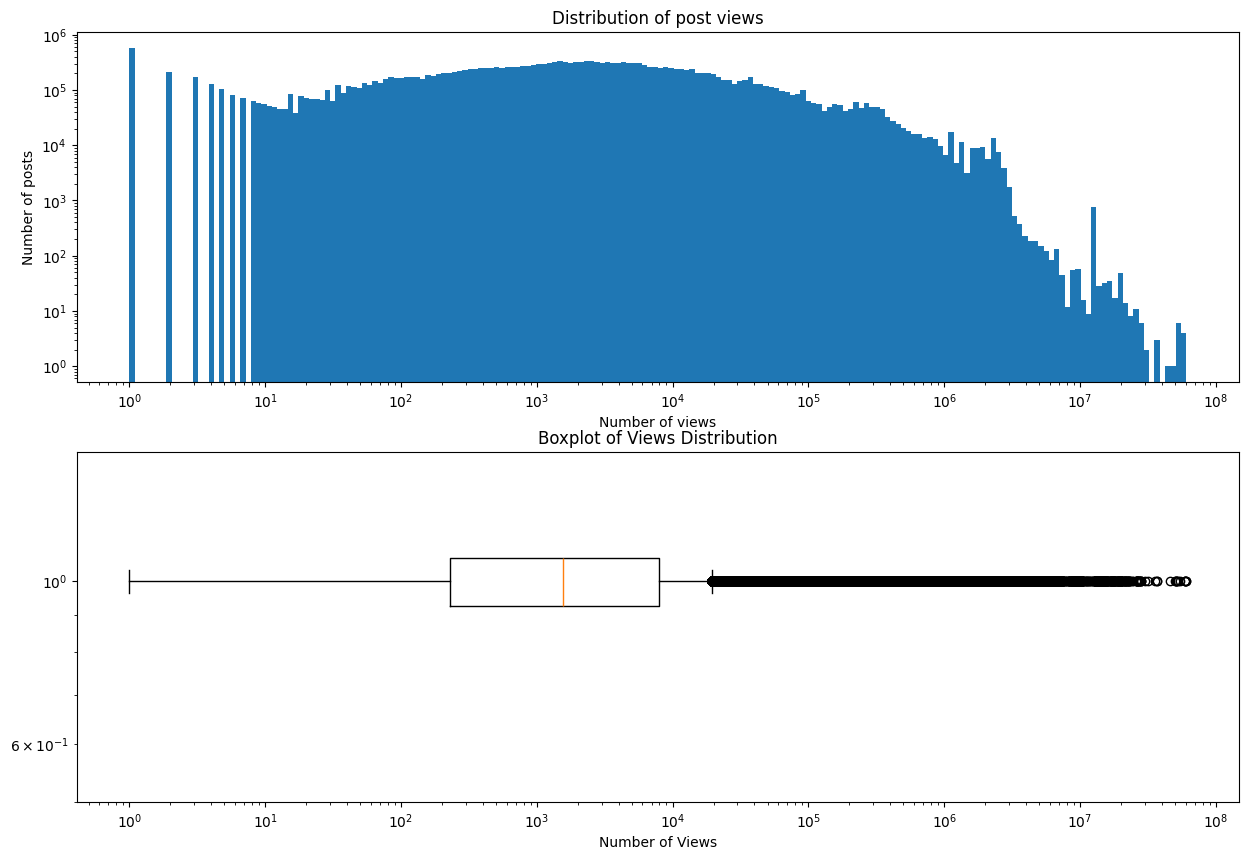

In [12]:
%load_ext autoreload
%autoreload 2
from visualize import plot_loghist


all_views = [v for posts in G.es['views'] for v in posts if v]

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

plot_loghist(all_views, bins=200, ax=axs[0])

axs[0].set_xlabel("Number of views")
axs[0].set_ylabel("Number of posts")
axs[0].set_title("Distribution of post views")

axs[1].boxplot(all_views, vert=False)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Number of Views')
axs[1].set_title('Boxplot of Views Distribution')

plt.show()

In [13]:
# Find strongly connected components
components = G.components(mode="weak")

# Print components as a list of vertex indices
component_sizes = [len(c) for c in components]

print("Number of components:", len(component_sizes))
print("Min size of the component:", np.min(component_sizes))
print("Max size of the component:", np.max(component_sizes))

Number of components: 4238
Min size of the component: 2
Max size of the component: 265660


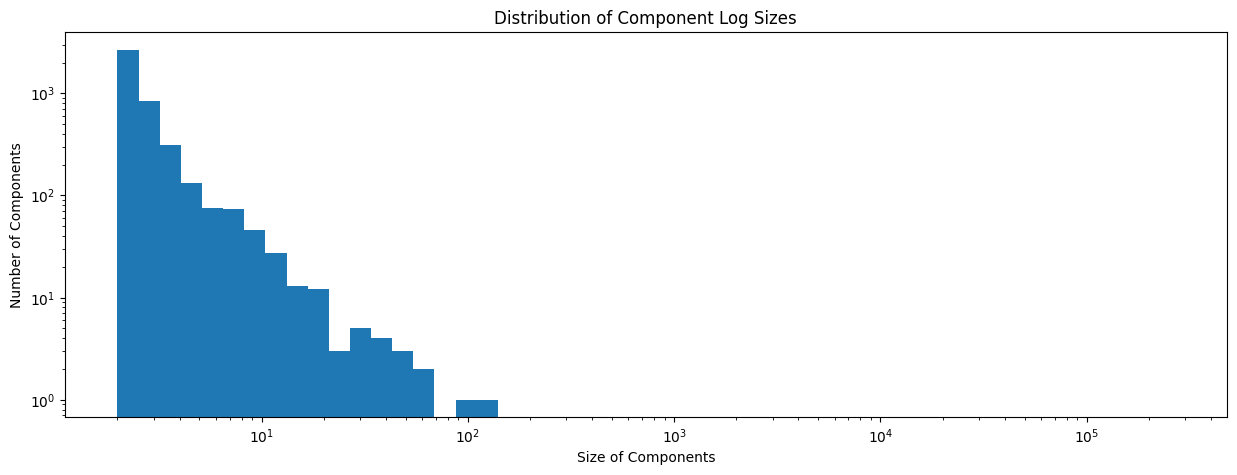

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


plot_loghist(component_sizes, bins=50)
plt.xlabel("Size of Components")
plt.ylabel("Number of Components")
plt.title("Distribution of Component Log Sizes")

plt.show()

In [15]:
import heapq

top_component_sizes = heapq.nlargest(5, component_sizes)
print(top_component_sizes)

[265660, 132, 106, 64, 59]


<!-- #collapse -->
## Make a filtered subgrpaph

In [16]:
H = G.copy()

In [17]:
print("Edges count:", H.ecount())
print("Vertices count:", H.vcount())

Edges count: 929891
Vertices count: 278500


<!-- #collapse -->
### Filter important posts by views

In [18]:
Q1 = np.percentile(all_views, 25)
Q3 = np.percentile(all_views, 75)
IQR = Q3 - Q1
views_upper_threshold = Q3 + 1.5 * IQR
views_upper_threshold

np.float64(19658.0)

In [19]:
# Filter dates and views based on views_upper_threshold
removed_edges = 0
for edge in tqdm(H.es):
    filtered_meta = [(date, view, post_id) for date, view, post_id in zip(edge['dates'], edge['views'], edge['post_ids']) if view and view >= views_upper_threshold]
    if filtered_meta:
        edge['dates'], edge['views'], edge['post_ids'] = zip(*filtered_meta)
    else:
        removed_edges += 1
        edge['dates'], edge['views'], edge['post_ids'] = [], [], []

# Recalculate weights
prev_weights = sum(H.es['weight'])
H.es['weight'] = [len(edge['views']) for edge in H.es]
cur_weights = sum(H.es['weight'])
print(f"Number of removed posts: {prev_weights - cur_weights}")


prev_edges = H.ecount()
# Delete edges with weight 0
H.delete_edges([edge.index for edge in H.es if edge['weight'] == 0])
cur_edges = H.ecount()
print(f"Number of removed edges: {prev_edges - cur_edges}")


prev_vertices = H.vcount()
# Delete unconnected vertices
H.vs.select(_degree_eq=0).delete()
cur_vertices = H.vcount()
print(f"Number of removed vertices: {prev_vertices - cur_vertices}")

# Count deleted vertices


100%|██████████| 929891/929891 [00:03<00:00, 236198.08it/s]


Number of removed posts: 22574945
Number of removed edges: 687592
Number of removed vertices: 226131


In [20]:
print("Edges count:", H.ecount())
print("Vertices count:", H.vcount())

Edges count: 242299
Vertices count: 52369


### Filter important links by number of reposting

In [21]:
Q1 = np.percentile(all_weights, 25)
Q3 = np.percentile(all_weights, 75)
IQR = Q3 - Q1
weights_upper_threshold = Q3 + 1.5 * IQR
weights_upper_threshold

np.float64(11.0)

In [22]:
# Recalculate weights
prev_weights = sum(H.es['weight'])
H.es['weight'] = [w if w > weights_upper_threshold else 0 for w in H.es['weight']]
cur_weights = sum(H.es['weight'])
print(f"Number of removed posts: {prev_weights - cur_weights}")

prev_edges = H.ecount()
# Delete edges with weight 0
H.delete_edges([edge.index for edge in H.es if edge['weight'] == 0])
cur_edges = H.ecount()
print(f"Number of removed edges: {prev_edges - cur_edges}")


prev_vertices = H.vcount()
# Delete unconnected vertices
H.vs.select(_degree_eq=0).delete()
cur_vertices = H.vcount()
print(f"Number of removed vertices: {prev_vertices - cur_vertices}")


Number of removed posts: 493871
Number of removed edges: 215332
Number of removed vertices: 40841


In [23]:
print("Edges count:", H.ecount())
print("Vertices count:", H.vcount())

Edges count: 26967
Vertices count: 11528


In [24]:
# Analize the main component of the graph
components = H.components(mode="weak")
component_sizes = [len(c) for c in components]

H = H.subgraph(components[np.argmax(component_sizes)])

In [25]:
from scipy.stats import describe
import numpy as np

print("Number of vertices:", H.vcount(), f"(reduction: {(1 - H.vcount() / G.vcount()) * 100:.1f}%)")
print("Number of edges:", H.ecount(), f"(reduction: {(1 - H.ecount() / G.ecount()) * 100:.1f}%)")
print("Number of posts:", sum(H.es['weight']), f"(reduction: {(1 - sum(H.es['weight']) / sum(G.es['weight'])) * 100:.1f}%)")

print("Min weight:", np.min(H.es['weight']))
print("Max weight:", np.max(H.es['weight']))

Number of vertices: 9106 (reduction: 96.7%)
Number of edges: 25175 (reduction: 97.3%)
Number of posts: 2541288 (reduction: 90.2%)
Min weight: 12
Max weight: 30953


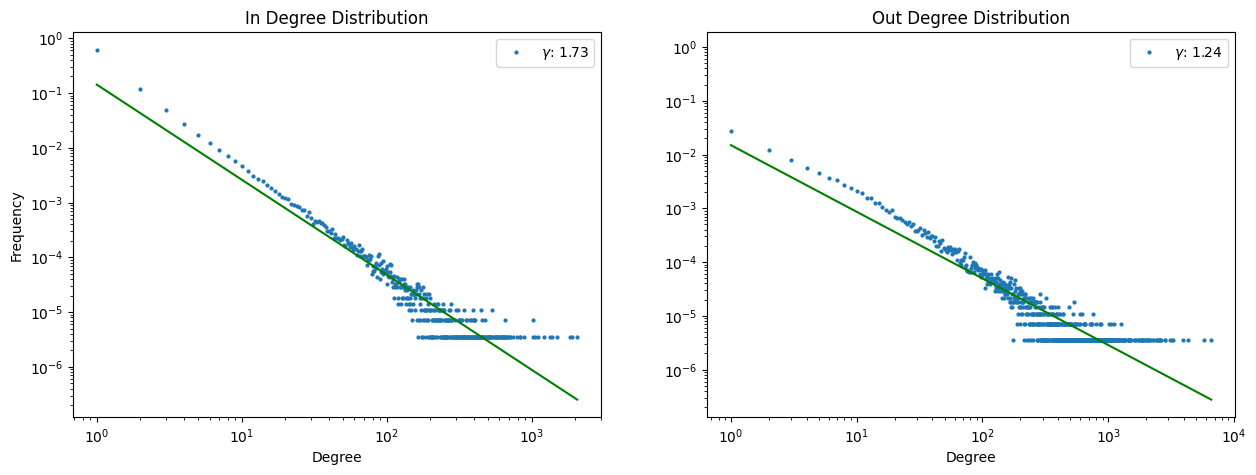

In [26]:
from scipy.stats import linregress


# degrees = np.array()

# # # Избегаем узлов с нулевой степенью
# degrees = degrees[degrees > 0]

# # Уникальные степени и их частоты
unique_indegrees, incounts = np.unique(G.indegree(), return_counts=True)
unique_outdegrees, outcounts = np.unique(G.outdegree(), return_counts=True)


# # Нормализуем частоты
inpk = incounts / incounts.sum()
outpk = outcounts / outcounts.sum()


fig, axs = plt.subplots(1, 2)
axs[0].loglog(unique_indegrees, inpk, 'o', markersize=2)
axs[0].set_title("In Degree Distribution")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("Frequency")

# Линейная регрессия
slope, intercept, r_value, p_value, std_err = linregress(np.log(unique_indegrees[unique_indegrees > 0]), np.log(inpk[unique_indegrees > 0]))
axs[0].plot(unique_indegrees[unique_indegrees > 0], unique_indegrees[unique_indegrees > 0] ** slope * np.exp(intercept), 'g')
axs[0].legend([rf"$\gamma$: {-slope:.2f}"])


axs[1].loglog(unique_outdegrees, outpk, 'o', markersize=2)
axs[1].set_title("Out Degree Distribution")
axs[1].set_xlabel("Degree")

# Линейная регрессия
slope, intercept, r_value, p_value, std_err = linregress(np.log(unique_outdegrees[unique_outdegrees > 0]), np.log(outpk[unique_outdegrees > 0]))
axs[1].plot(unique_outdegrees[unique_outdegrees > 0], unique_outdegrees[unique_outdegrees > 0] ** slope * np.exp(intercept), 'g')
axs[1].legend([rf"$\gamma$: {-slope:.2f}"])

plt.show()


In [17]:
# H.es['weight'] = [np.log1p(w) for w in H.es['weight']]

<!-- #collapse -->
## Visualize the Subgraph

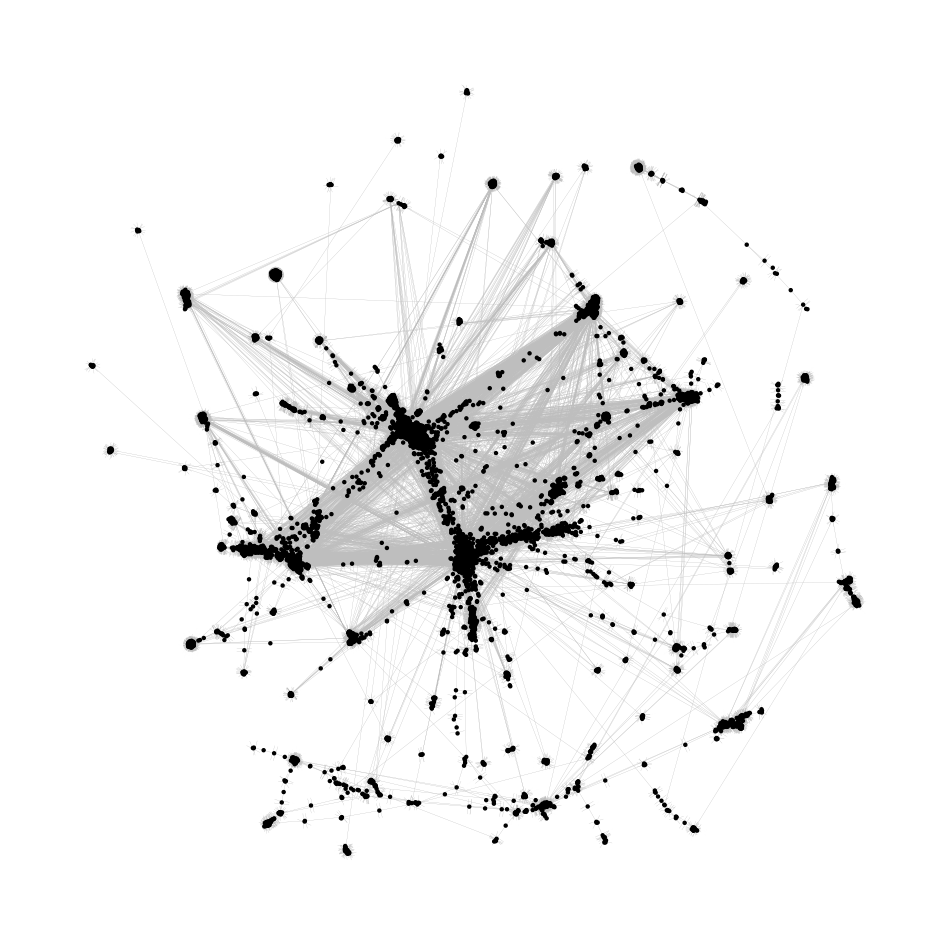

In [29]:
import igraph as ig
import matplotlib.pyplot as plt


# # Assign labels to nodes (optional)
# g.vs['label'] = [f"Node {i}" for i in range(g.vcount())]

# Define the layout using Fruchterman-Reingold
# inverse_weights = [1 / w for w in H.es['weight']]
# layout = H.layout_sugiyama(weights=inverse_weights)
# layout = H.layout_fruchterman_reingold(weights=1 / np.log1p(H.es['weight']))

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 12))
ig.plot(
    H,
    target=ax,
    vertex_size=3,
    edge_arrow_size=0.1,  # Size of arrows to show edge direction
    vertex_color="black",
    vertex_border_width=0,  # Node color
    edge_color="gray",  # Edge color
    edge_width=0.1,
)
plt.show()

In [30]:
H.summary()

'IGRAPH D-W- 9106 25175 -- \n+ attr: id (v), dates (e), post_ids (e), views (e), weight (e)'

<!-- #collapse -->
## Save the Subrgraph

In [31]:
len(H.vs)

9106

In [32]:
for edge in H.es:
    edge['datesjson'] = json.dumps([str(d) for d in edge['dates']])  # Serialize list to string
    edge['viewsjson'] = json.dumps(edge['views'])  # Serialize list to string
    edge['postidsjson'] = json.dumps(edge['post_ids'])

H.write_gml("./data/1kk_graph.gml")

/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_6845/1126951147.py:6: RuntimeWarning: The non-numeric, non-string, non-boolean edge attribute 'dates' was ignored. at src/io/gml.c:1285
  H.write_gml("./data/1kk_graph.gml")
/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_6845/1126951147.py:6: RuntimeWarning: The non-numeric, non-string, non-boolean edge attribute 'views' was ignored. at src/io/gml.c:1285
  H.write_gml("./data/1kk_graph.gml")
/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_6845/1126951147.py:6: RuntimeWarning: The non-numeric, non-string, non-boolean edge attribute 'post_ids' was ignored. at src/io/gml.c:1285
  H.write_gml("./data/1kk_graph.gml")


<!-- #collapse -->
# Clusterization

In [33]:
from igraph import Graph
import json
from datetime import datetime


H = Graph.Read_GML('./data/1kk_graph.gml')
H.es['dates'] = [datetime.fromisoformat(d) for dates in H.es['datesjson'] for d in json.loads(dates)]
H.es['views'] = [json.loads(views) for views in H.es['viewsjson']]
H.es['post_ids'] = [json.loads(post_ids) for post_ids in H.es['postidsjson']]

# Completely remove the attributes
del(H.es['datesjson'])
del(H.es['viewsjson'])
del(H.es['postidsjson'])

In [34]:
print(H.summary())

IGRAPH D-W- 9106 25175 -- 
+ attr: id (v), dates (e), post_ids (e), views (e), weight (e)


In [35]:
from igraph import VertexClustering

H_copy = H.copy()
del(H_copy.es['dates'])
del(H_copy.es['views'])
del(H_copy.es['post_ids'])


H_undirected = H_copy.as_undirected(mode="collapse", combine_edges="sum")

# Find the best partition
louvain_clusters = H_undirected.community_multilevel(weights=H_undirected.es['weight'])

print("Number of clusters:", len(louvain_clusters))

Number of clusters: 87


In [36]:
from igraph import compare_communities as compare

print("Louvain Modularity:", louvain_clusters.modularity)

# Compute Normalized Cut (Ncut)
cut_weight = 0
total_weight = 0

# Iterate over all edges in the graph
for edge in H.es:
    # Check if 'weight' exists, otherwise set a default weight of 1
    edge_weight = edge['weight'] # if 'weight' in edge.attributes() else 1
    total_weight += edge_weight

    # Get the source and target vertices for the edge
    u, v = edge.source, edge.target
    if louvain_clusters.membership[u] != louvain_clusters.membership[v]:  # If u and v are in different clusters
        cut_weight += edge_weight

# Compute Ncut (cut_weight / total_weight)
ncut = cut_weight / total_weight
print("Ncut:", ncut)


Louvain Modularity: 0.773522950460887
Ncut: 0.12769981206380387


In [37]:
H.vs["pagerank"] = H.pagerank(weights='weight')

H.vs["modularity_class"] = louvain_clusters.membership

/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_6845/119315462.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("tab20", num_clusters)


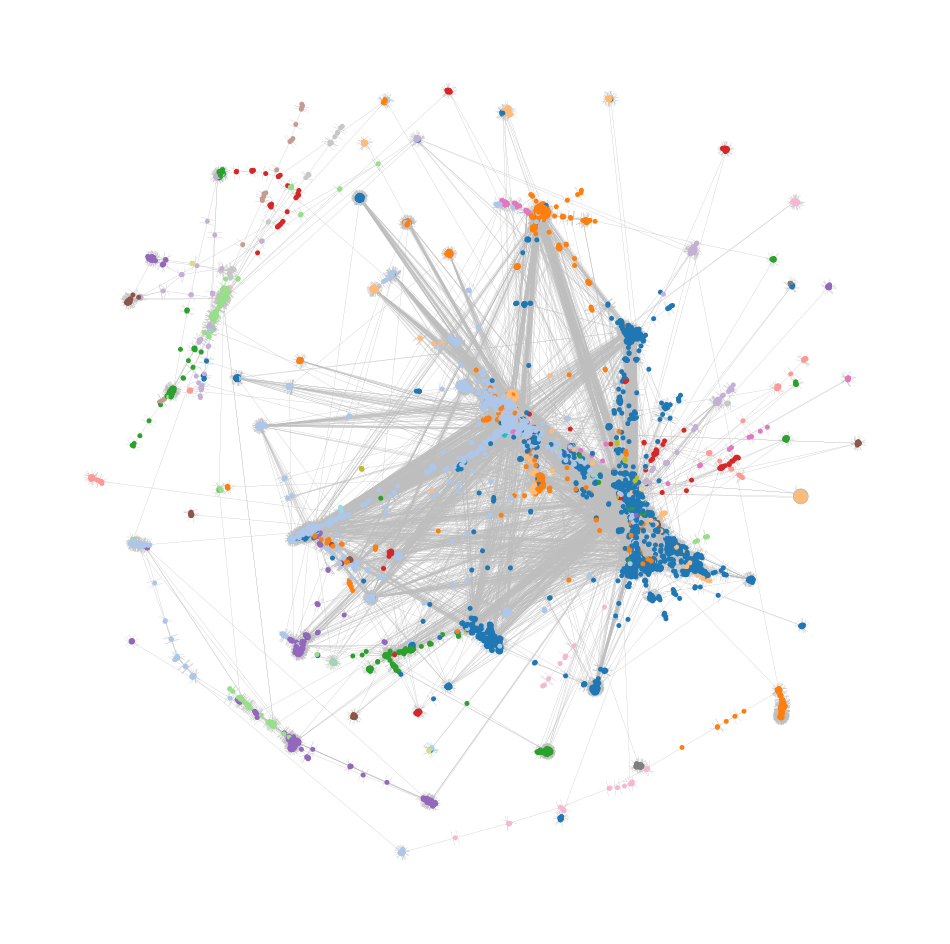

In [38]:
import igraph as ig
import matplotlib.pyplot as plt

num_clusters = len(louvain_clusters)
colormap = plt.cm.get_cmap("tab20", num_clusters)


# Map cluster membership to colors
vertex_colors = [colormap(cluster) for cluster in louvain_clusters.membership]

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 12))
ig.plot(
    H,
    target=ax,
    vertex_size=5,
    edge_arrow_size=0,  # Size of arrows to show edge direction
    vertex_color=vertex_colors,  # Node color based on cluster
    # vertex_border_width=0,
    vertex_frame_width=0,  # Убираем рамку вершины
    vertex_frame_color=None,  # Убираем цвет рамки вершины
    edge_color="gray",  # Edge color
    edge_width=0.1,
    # layout=layout,
)
plt.show()

<!-- #collapse -->
## Make a graph from clusters

In [39]:
%load_ext autoreload
%autoreload 2
from utils import get_cluster_graph

H_cluster = get_cluster_graph(H, louvain_clusters.membership)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
H_cluster.summary()

'IGRAPH DNW- 87 343 -- \n+ attr: name (v), weight (e)'

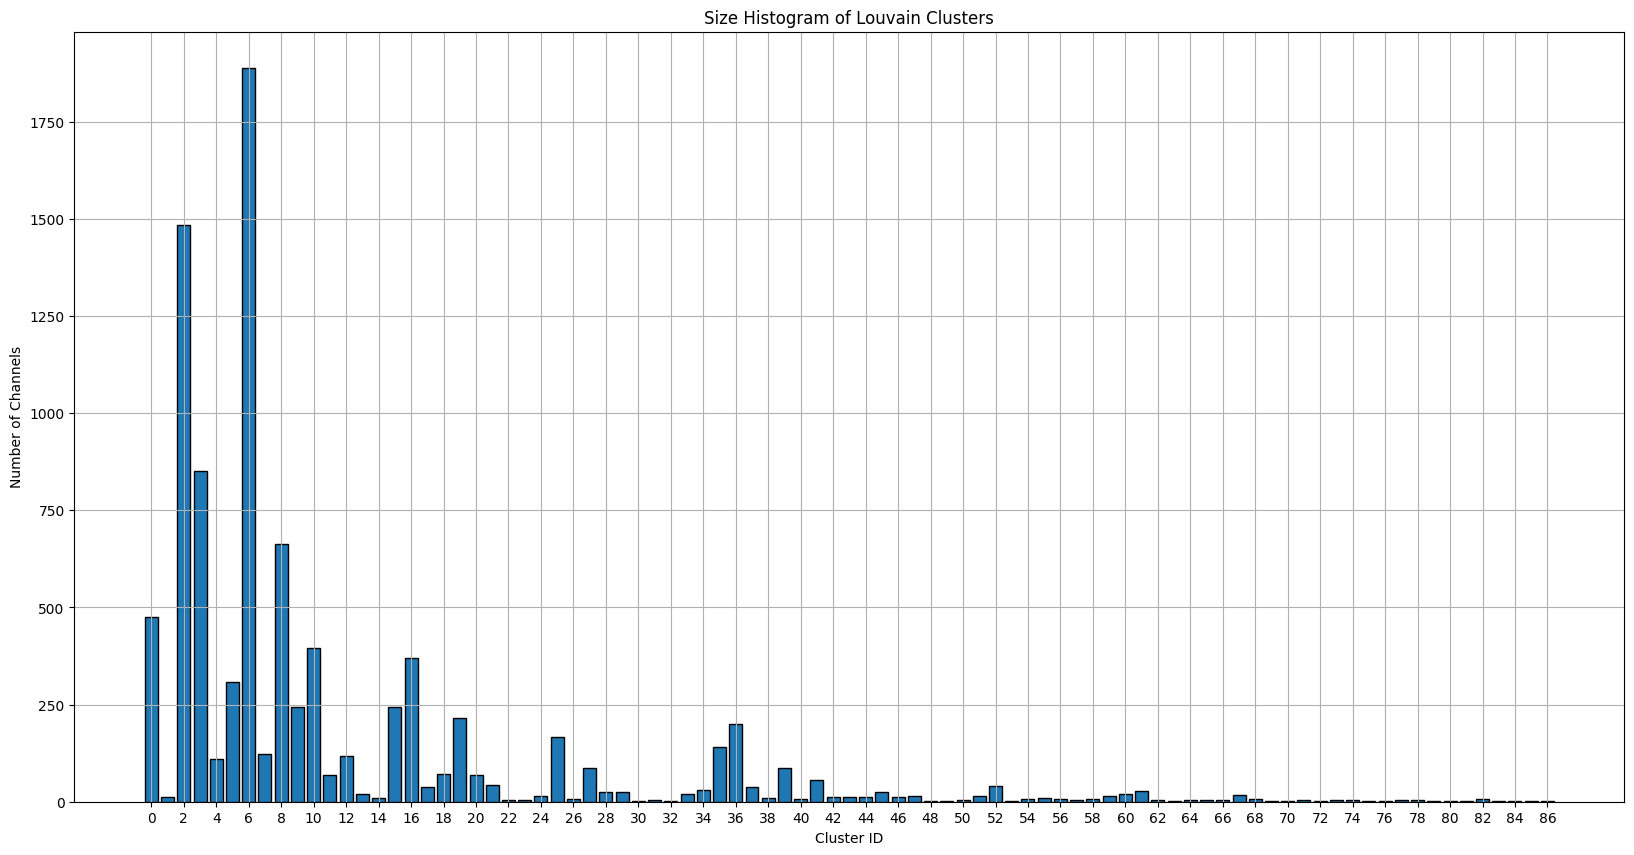

In [41]:
import matplotlib.pyplot as plt

# Get the sizes of each cluster
cluster_sizes = [len(cluster) for cluster in louvain_clusters]

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(range(len(cluster_sizes)), cluster_sizes, edgecolor='black')
plt.title('Size Histogram of Louvain Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Channels')
plt.xticks(range(0, len(cluster_sizes), 2), range(0, len(cluster_sizes), 2))
plt.grid(True)  # Add grid
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


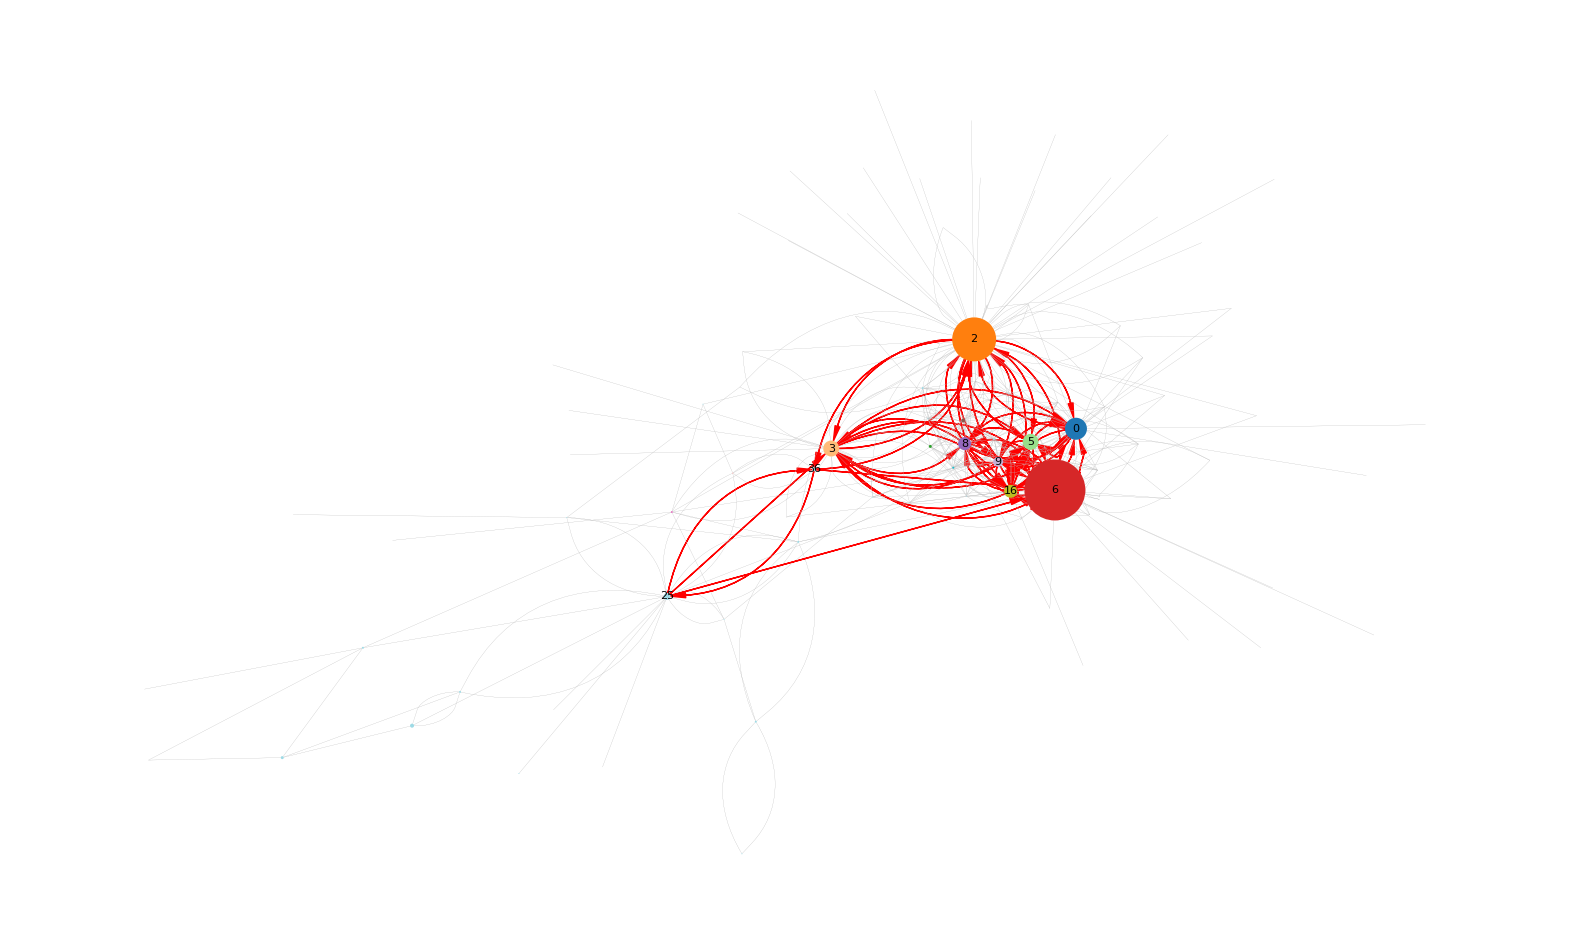

In [42]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from visualize import visualize_graph

pagerank_values = H_cluster.pagerank(weights=H_cluster.es['weight'])
top_clusters = sorted(range(len(pagerank_values)), key=lambda i: pagerank_values[i], reverse=True)[:10]

fig, ax = plt.subplots(figsize=(20, 12))
visualize_graph(H_cluster, ax, top_clusters)
plt.show()

In [43]:
# Identify the top 50 clusters based on PageRank values
top_clusters = sorted(range(len(pagerank_values)), key=lambda i: pagerank_values[i], reverse=True)[:15]
print("Top 50 clusters based on PageRank ranking:", top_clusters)

Top 50 clusters based on PageRank ranking: [6, 2, 0, 5, 3]


In [44]:
%load_ext autoreload
%autoreload 2
import pandas as pd

from utils import local_pagerank_igraph_weighted


# Compute local PageRank for each vertex
vertices = top_clusters

lp_df = pd.DataFrame()

for v in vertices:
    pr_values = local_pagerank_igraph_weighted(H_cluster, v)
    lp_df[v] = pd.Series(pr_values)[top_clusters]

lp_df.T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,6,2,0,5,3
6,0.377837,0.141624,0.093961,0.086584,0.047143
2,0.250607,0.277291,0.096951,0.063510,0.056845
0,0.256440,0.161128,0.231105,0.064945,0.050751
5,0.308835,0.124214,0.080573,0.221786,0.041384
3,0.230885,0.167155,0.088175,0.058820,0.200068


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


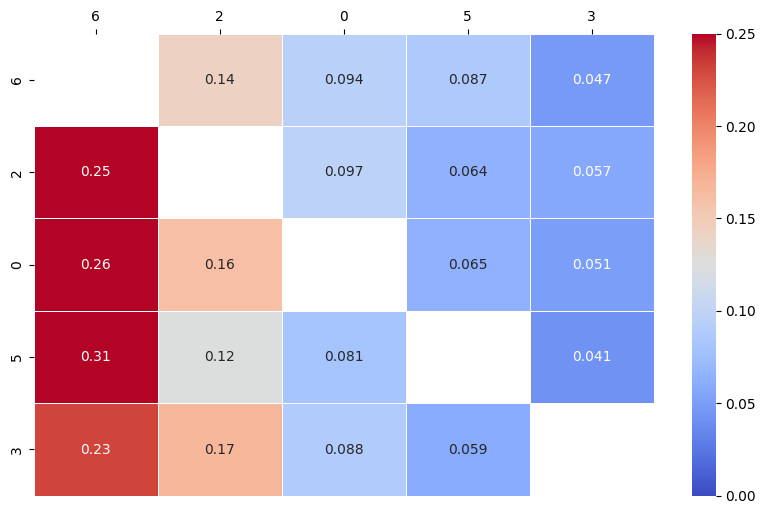

In [45]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from visualize import visualize_heatmap

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
visualize_heatmap(lp_df.T, ax)
plt.show()

<!-- #collapse -->
## Save clustered_graph

In [46]:
H_cluster.write_gml("./data/1kk_clustered_graph.gml")

/var/folders/d3/tlp4l7t96hs7g1hs5kw3d44r0000gn/T/ipykernel_6845/2573697062.py:1: RuntimeWarning: The non-numeric, non-string, non-boolean vertex attribute 'label' was ignored. at src/io/gml.c:1213
  H_cluster.write_gml("./data/1kk_clustered_graph.gml")


In [47]:
import json

with open("./data/louvain_clusters_membership.json", "w") as f:
    json.dump(louvain_clusters.membership, f)


<!-- #collapse -->
# Time analizes

<!-- #collapse -->
## Visualize cluster relations during the time

In [48]:
from igraph import Graph
from datetime import datetime

H = Graph.Read_GML('./data/1kk_graph.gml')
H.es['dates'] = [[datetime.fromisoformat(d) for d in json.loads(dates)] for dates in H.es['datesjson']]
H.es['views'] = [json.loads(views) for views in H.es['viewsjson']]
H.es['post_ids'] = [json.loads(post_ids) for post_ids in H.es['postidsjson']]


del(H.es['datesjson'])
del(H.es['viewsjson'])
del(H.es['postidsjson'])

In [49]:
H_cluster = Graph.Read_GML('./data/1kk_clustered_graph.gml')

In [55]:
H_cluster.summary()

'IGRAPH DNW- 87 343 -- \n+ attr: id (v), name (v), weight (e)'

In [50]:
import json

with open("./data/louvain_clusters_membership.json") as f:
    louvain_clusters_membership = json.load(f)

In [52]:
%load_ext autoreload
%autoreload 2
from utils import filter_graph_by_year

H_2021 = filter_graph_by_year(H, 2021)
H_2021.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'IGRAPH D-W- 9106 6281 -- \n+ attr: id (v), dates (e), post_ids (e), views (e), weight (e)'

In [54]:
%load_ext autoreload
%autoreload 2
from utils import get_cluster_graph


H_2021_cluster = get_cluster_graph(H_2021, louvain_clusters_membership)
H_2021_cluster.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'IGRAPH DNW- 87 165 -- \n+ attr: name (v), weight (e)'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


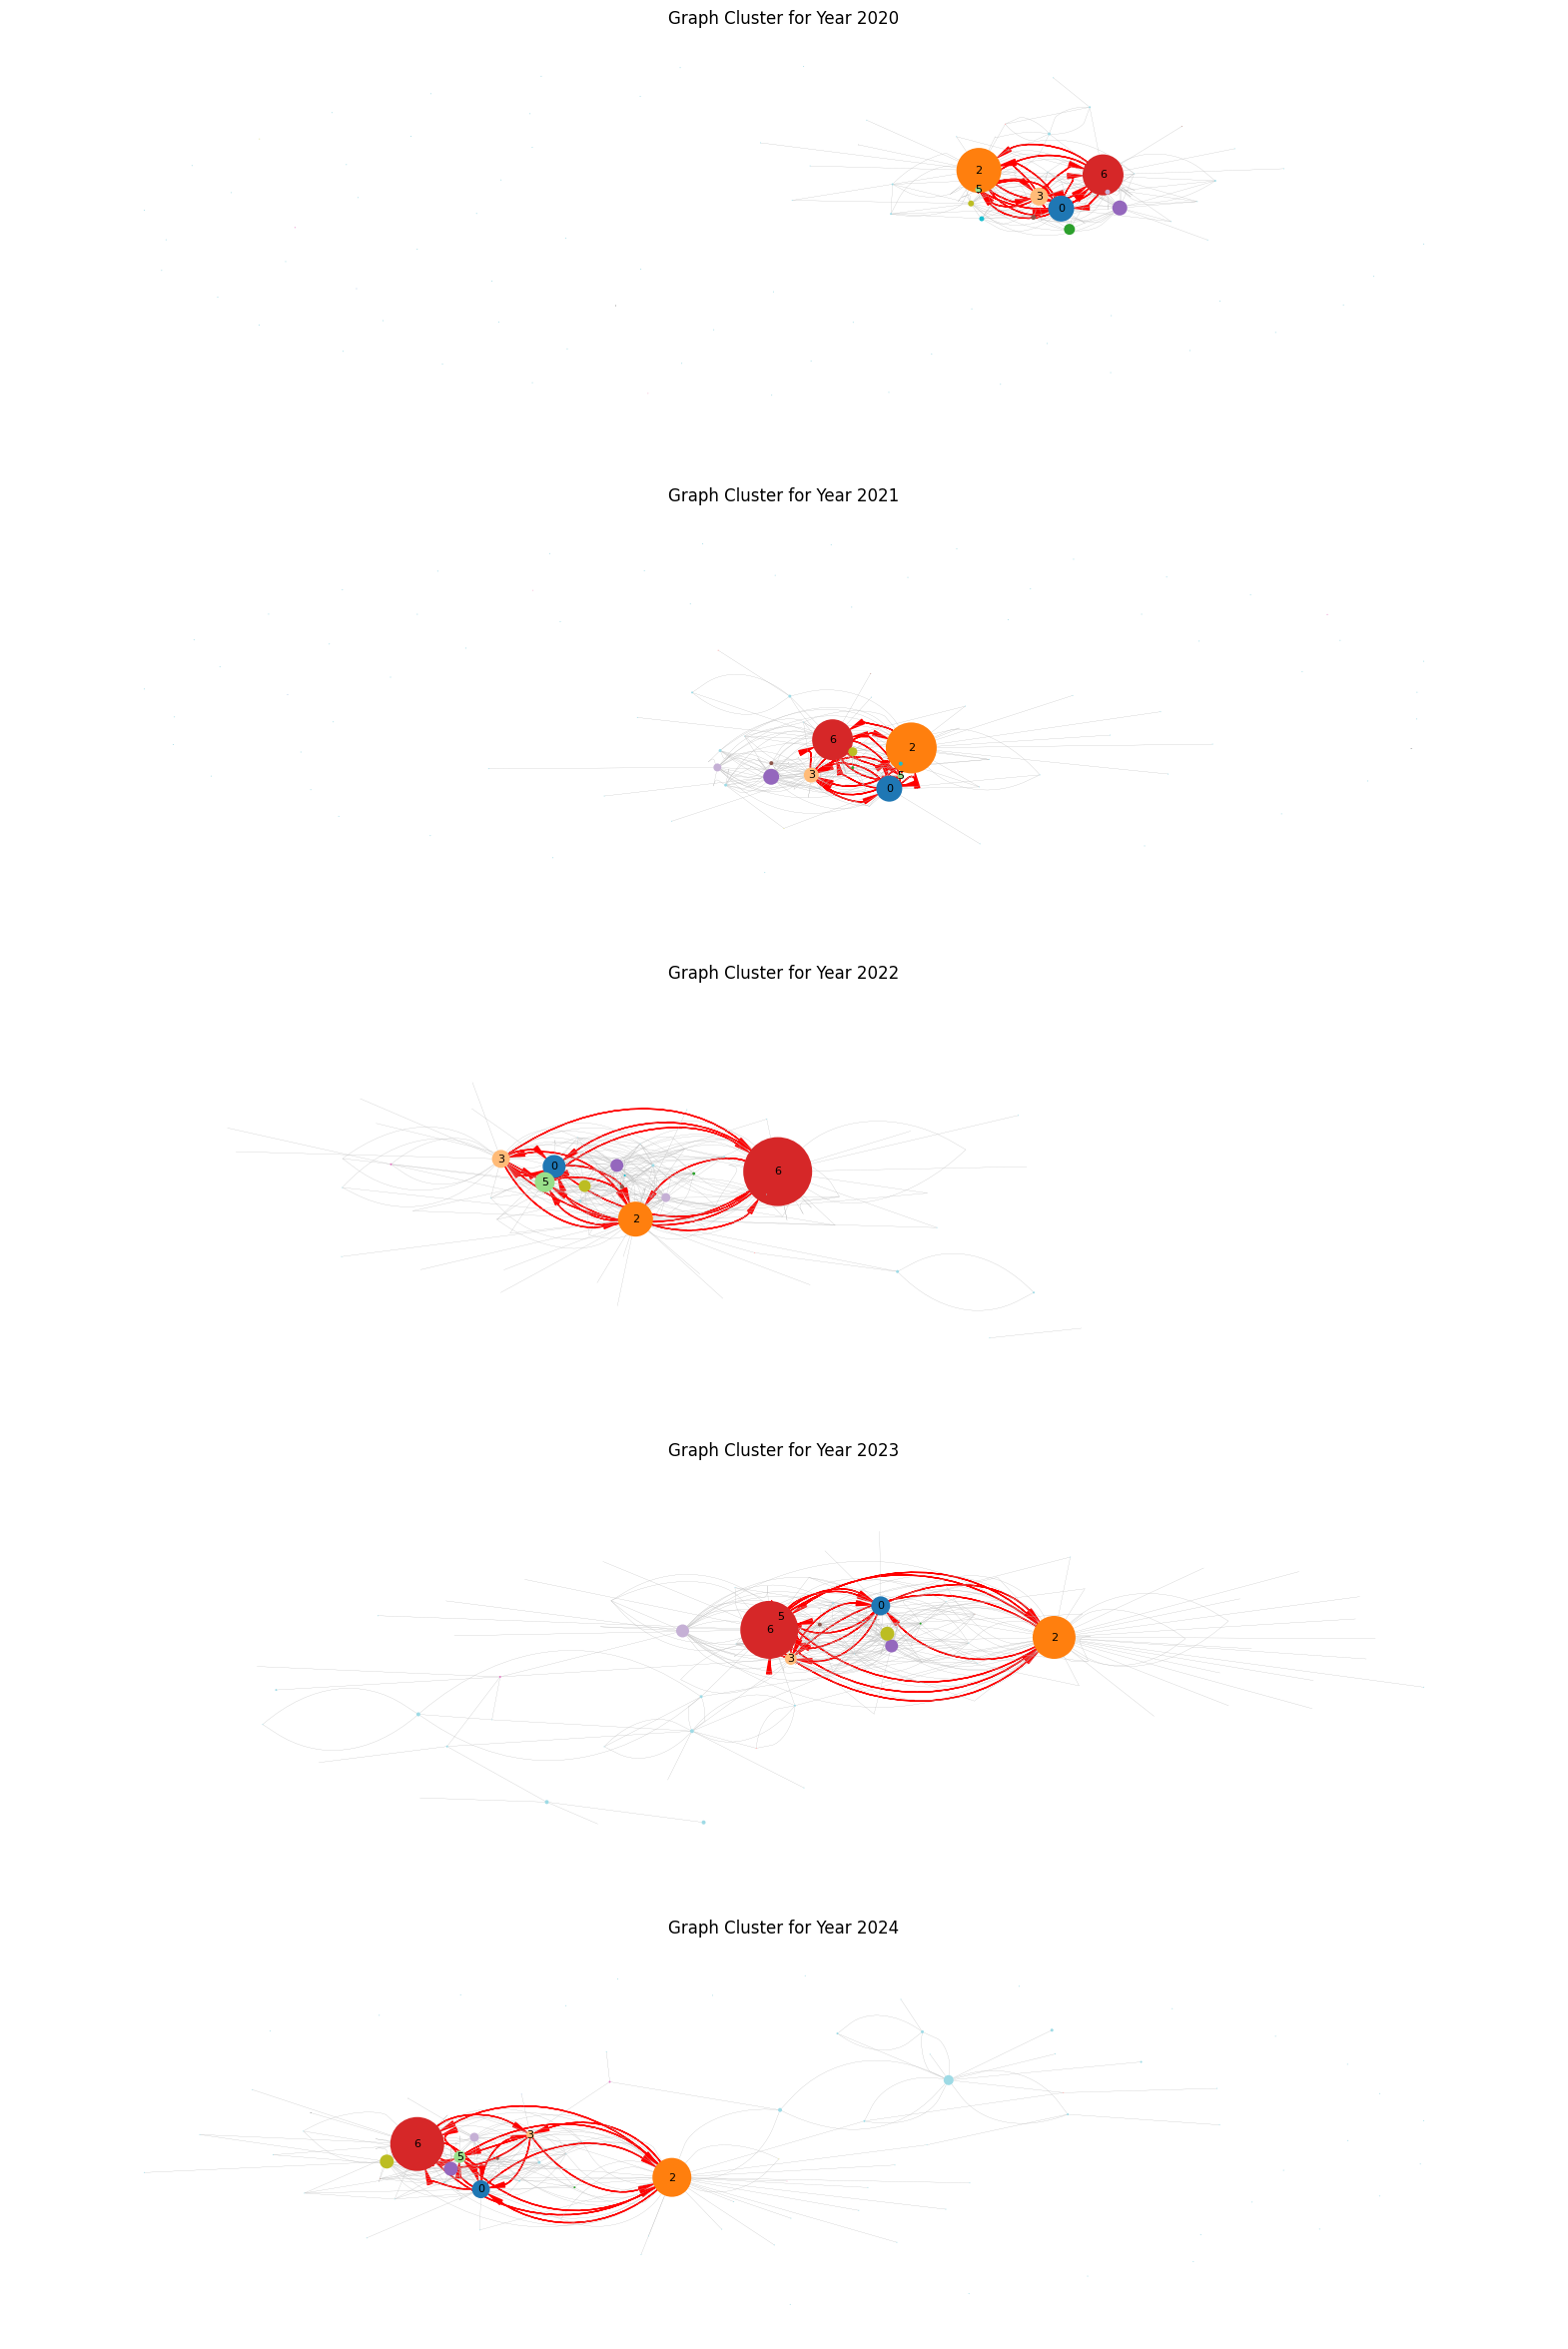

In [56]:
%load_ext autoreload
%autoreload 2
from utils import get_cluster_graph, filter_graph_by_year
from visualize import visualize_graph


years = [2020, 2021, 2022, 2023, 2024]
# Plot the graph
pagerank_values = H_cluster.pagerank(weights=H_cluster.es['weight'])
top_clusters = sorted(range(len(pagerank_values)), key=lambda i: pagerank_values[i], reverse=True)[:5]

fig, axs = plt.subplots(len(years), figsize=(20, len(years) * 6))


for i, y in enumerate(years):
    H_year = filter_graph_by_year(H, y)
    H_year_cluster = get_cluster_graph(H_year, louvain_clusters_membership)

    visualize_graph(H_year_cluster, axs[i], top_clusters)
    axs[i].set_title(f"Graph Cluster for Year {y}")

plt.show()


<!-- #collapse -->
## Visualize cluster closeness during the time

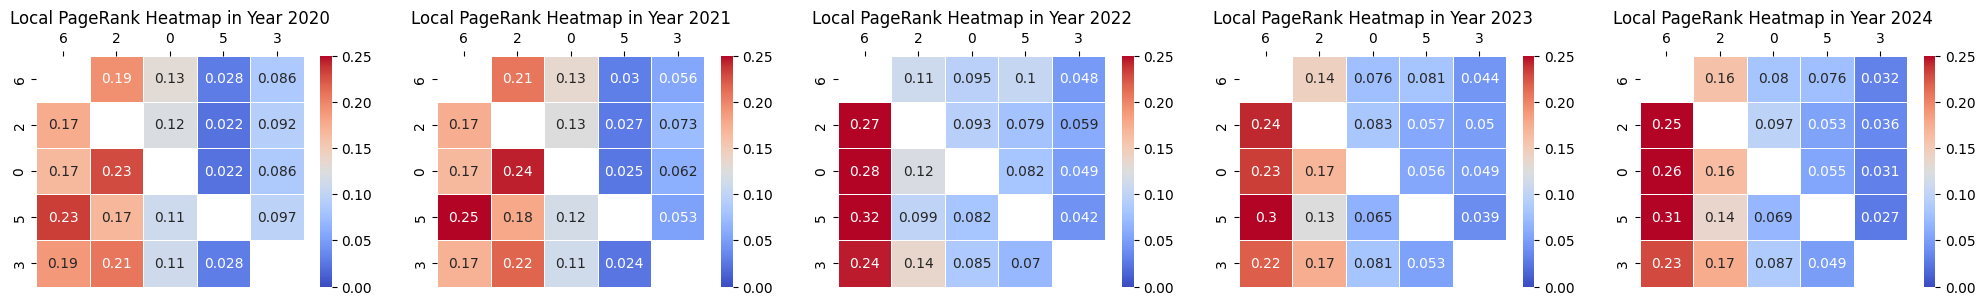

In [57]:
# Plot the heatmap

years = [2020, 2021, 2022, 2023, 2024]

pagerank_values = H_cluster.pagerank(weights=H_cluster.es['weight'])
top_clusters = sorted(range(len(pagerank_values)), key=lambda i: pagerank_values[i], reverse=True)[:5]


fig, axs = plt.subplots(1, len(years), figsize=(5 * len(years), 3))


for i, y in enumerate(years):
    lp_df = pd.DataFrame()
    H_year = filter_graph_by_year(H, y)
    H_year_cluster = get_cluster_graph(H_year, louvain_clusters_membership)

    for v in top_clusters:
        pr_values = local_pagerank_igraph_weighted(H_year_cluster, v)
        lp_df[v] = pd.Series(pr_values)[top_clusters]

    visualize_heatmap(lp_df.T, axs[i])
    axs[i].set_title(f"Local PageRank Heatmap in Year {y}")

plt.show()

<!-- #collapse -->
## Visualize channels inside the main clusters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


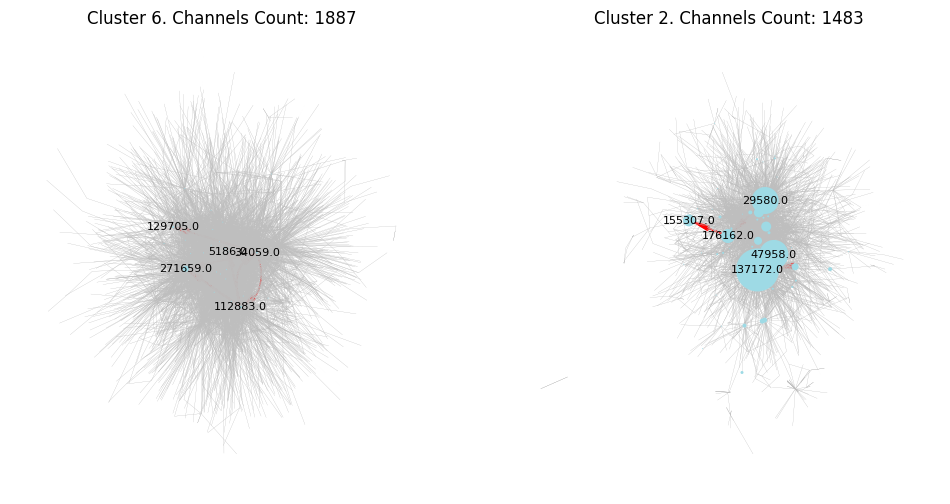

In [60]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from visualize import visualize_graph


cluster_ids = [6, 2]
top_clusters_num = 5

fig, axs = plt.subplots(1, len(cluster_ids), figsize=(6 * len(cluster_ids), 6))

for ind, cid in enumerate(cluster_ids):
    membership_cid = [i for i, v in enumerate(louvain_clusters_membership) if v == cid]
    H_cid = H.subgraph(membership_cid).copy()

    pagerank_values = H_cid.pagerank(weights=H_cid.es['weight'])
    top_cid_channels = sorted(range(len(pagerank_values)), key=lambda i: pagerank_values[i], reverse=True)[:top_clusters_num]

    visualize_graph(H_cid, axs[ind], top_cid_channels, H_cid.vs[top_cid_channels]['id'], size_coefficient=700)
    axs[ind].set_title(f"Cluster {cid}. Channels Count: {len(membership_cid)}")

plt.show()